In [2]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
from pprint import pprint
import os 
import random
import experiment_helpers as eh
import utils
import bisect
sns.set()

In [3]:
G = gg.ba_graph(10 * 1000, 10)
tau = 0.5 
gamma = 1.0 
rho = 10 / (10 * 1000)
tmax = float('inf')

In [ ]:
tup = Q.quarantine_by_prop(G, tau, gamma, rho, [0.05] * 20, tmax, term_I=True)

In [62]:
def get_hardI_lim(G, tau, gamma, rho, maxI, hard_r=None):
    # maxI = FRACTION OF NODES
    prop_list = [maxI for _ in range(round(1 / maxI) + 1)] 
    outputs = [] 
    original_G = G 
    init_infect = round(rho * len(G))
    new_rho = init_infect / len(G)
    
    hard_r = hard_r or 2.0
    r_threshold = hard_r
    for prop in prop_list:
        G, tup = Q.run_until_prop_IR(G, tau, gamma, new_rho, float('inf'), 
                                     prop, total_nodes=len(original_G), 
                                     term_I=True, final_R = r_threshold,
                                     return_summary=False)
        
        new_rho = init_infect / len(G)
        r_threshold = hard_r - (1 - len(G) / len(original_G))
        outputs.append(tup)
        if r_threshold <= 0.001 or tup.I[-1] == 0:
            break 
            
            
    
    
    if tup.I[-1] >0: 
        tup = Q.run_until_time(G, tau, gamma, new_rho, float('inf'))[1]
        outputs.append(tup)
    return Q.TupleSIR.cat(outputs), tup

In [64]:
# Now sweep over quarantine ranges and check values...
RESOLUTION = 100
NUM_ITER = 5
final_R_data = {}
final_tup_data = {}
for i in range(1, RESOLUTION):
    print(i)
    prop = i / RESOLUTION
    final_R_data[prop] = [] 
    final_tup_data[prop] = [] 
    for j in range(NUM_ITER):
        out_tup, final_tup = get_hardI_lim(G, tau, gamma, rho, prop)
        final_R_data[prop].append(out_tup.get_final_R())
        final_tup_data[prop].append(final_tup)

        
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [67]:
pairs = sorted(final_R_data.items())

In [77]:
# Want to plot three things:
# Standard plot  
# Standard plot lacking the final wave 
# Final wave 
original_vals = sorted(final_R_data.items())
final_waves = sorted((k, [_.get_final_R() for _ in v]) for k,v in final_tup_data.items()) 
all_but_final = [(x[0], np.array(x[1]) - np.array(y[1])) for x,y in zip(original_vals, final_waves)]


Text(0.5, 1.0, 'Total Infected Nodes vs. Hard Infection Thresholds')

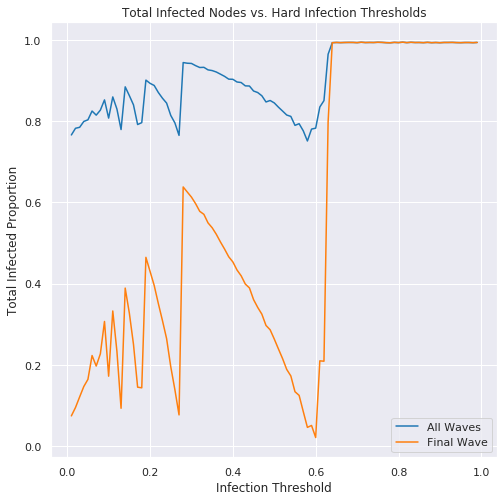

In [96]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([_[0] for _ in original_vals], [np.mean(_[1])/10000 for _ in original_vals], c=utils.c(0), 
        label='All Waves')
ax.plot([_[0] for _ in final_waves], [np.mean(_[1])/10000 for _ in final_waves], c=utils.c(1), label="Final Wave")
#ax.plot([_[0] for _ in final_waves], [np.mean(_[1])/10000 for _ in all_but_final], c=utils.c(2), label="All but Final Wave")

ax.legend(loc='lower right')
ax.set_xlabel("Infection Threshold")
ax.set_ylabel("Total Infected Proportion")
ax.set_title("Total Infected Nodes vs. Hard Infection Thresholds")

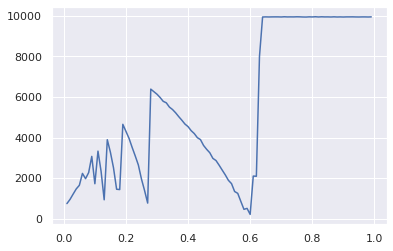

In [75]:
plt.plot(*zip(*final_tups))